Importing the libraries

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, cross_validate

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score,  f1_score

Exploring the Data, removing uneeded columns

In [141]:
df = pd.read_csv("data.csv")

In [142]:
# dropping the index column
df.drop(columns=["Unnamed: 0"], inplace=True)

In [143]:
df

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,48,3,2,24.0,0,0,14,31,19,12,3,1,0,1
859,0,0,2,35.0,0,0,14,31,19,12,3,1,0,0
860,3,1,1,49.4,0,0,14,31,19,12,3,1,0,0
861,24,9,1,49.4,0,0,14,31,19,12,3,1,0,0


# KNN

In [144]:
# Importing KNN library
from sklearn.neighbors import KNeighborsClassifier

In [145]:
# Splitting the data
columns = df.columns
X = df[columns[:-1]]
y = df[columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=2)
# comment the next line if using GridsearchCV or cross_val_predict
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state=2)


In [146]:
# array of different k values
k_range = np.arange(1,20)

In [147]:
# corss_val_predict
# Training set contains the validation se (cross validation)
# measuring the accuracy and the recall score for different valeus of k
accs_cv = []
recalls_cv = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = cross_val_predict(knn, X_train, y_train, cv = 10)
    accs_cv.append(accuracy_score(y_train, y_pred))
    recalls_cv.append(recall_score(y_train, y_pred))

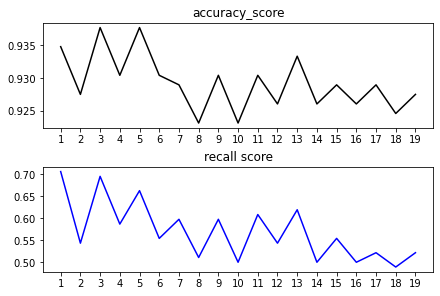

In [148]:
# plotting them to get the get the best value
fig, axes = plt.subplots(2, constrained_layout=True)
plt.setp(axes, xticks = k_range)

axes[0].plot(k_range, accs_cv, c="k")
axes[0].set_title("accuracy_score")

axes[1].plot(k_range, recalls_cv, c="b")
axes[1].set_title("recall score");


In [149]:
# from the previosu plots, it seems 3 is the optimal number for the number of neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

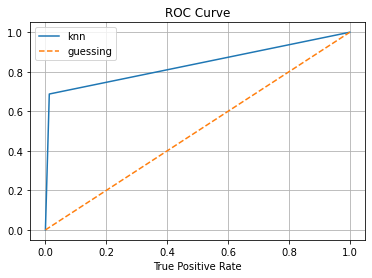

In [150]:
# Plotting the ROC Curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)
plt.plot(fpr_knn, tpr_knn, label = "knn");
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", label = "guessing")
plt.title("ROC Curve")
plt.xlabel("Flase Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()
plt.grid()

In [151]:
# Measuring the model with different classsification metrics
print(confusion_matrix(y_test, y_pred_knn))
print(f"precision: {precision_score(y_test, y_pred_knn) * 100:.2f}%")
print(f"recall: {recall_score(y_test, y_pred_knn) * 100:.2f}%")
print(f"f_1: {f1_score(y_test, y_pred_knn) * 100:.2f}%")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_knn) * 100:.2f}%")

[[155   2]
 [  5  11]]
precision: 84.62%
recall: 68.75%
f_1: 75.86%
roc_auc_score: 83.74%


- We're more concerned with the `recall`, to prevent any fatal case from misclassification as normal or recoverable case

- because the recall is `0.6875`, which is not very different from the prue guessing `0.5` ➡️ we need to improve our moddel

- Since the KNN is sensitive to noise, we will try to clean our data set

Data Plotting and cleaning

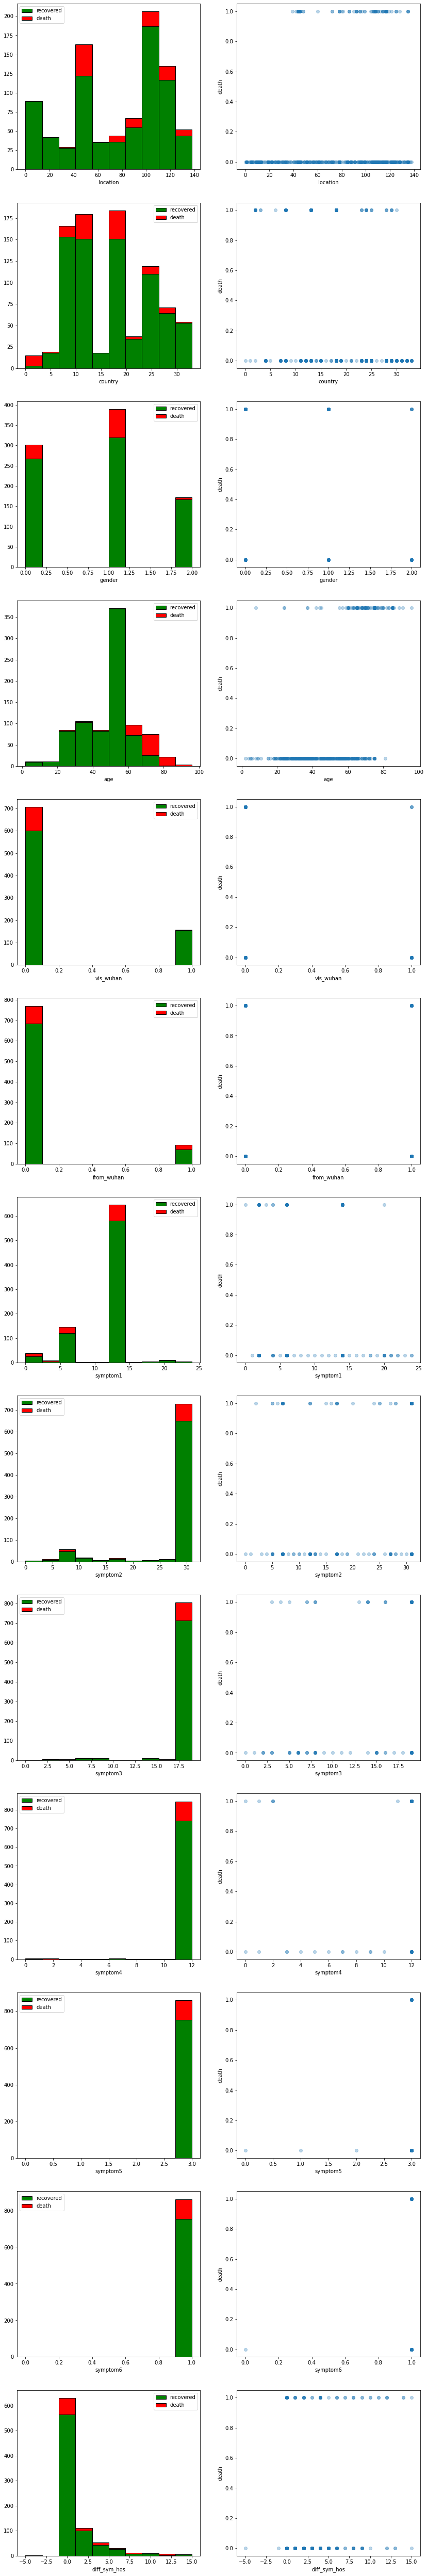

In [152]:
fig, axes = plt.subplots(nrows= 13, ncols=2, figsize = (14,91))
for i in range(len(df.columns) - 1):
    axes[i, 0].hist([df.query("result == 0")[df.columns[i]], df.query("result == 1")[df.columns[i]]], edgecolor ="k", histtype="barstacked", label=("recovered", "death"), color = ('g', 'r'))
    axes[i, 1].scatter(df[df.columns[i]], df["result"], alpha = 0.3);
    axes[i, 0].legend()
    axes[i, 0].set_xlabel(f"{df.columns[i]}");
    axes[i, 1].set_xlabel(f"{df.columns[i]}");
    axes[i, 1].set_ylabel(f"death");
    axes[i, 1].set_ylabel(f"death");
    

From the previous plots, we can remove some rows to improve the data quality

In [153]:
# age
indices = df.query("result == 0 & age > 74").index
print(len(indices))
df_knn = df.drop(indices)

9


In [154]:
# symptom1
indices = df_knn.query("result == 1 & symptom1 > 15").index
print(len(indices))
df_knn.drop(indices, inplace= True)

1


Repeat the previous steps

In [155]:
# Splitting the data
columns = df_knn.columns
X = df_knn[columns[:-1]]
y = df_knn[columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=2)
# comment the next line if using GridsearchCV or cross_val_predict
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state=2)


In [156]:
# corss_val_predict
# Training set contains the validation se (cross validation)
# measuring the accuracy and the recall score for different valeus of k
accs_cv = []
recalls_cv = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = cross_val_predict(knn, X_train, y_train, cv = 10)
    accs_cv.append(accuracy_score(y_train, y_pred))
    recalls_cv.append(recall_score(y_train, y_pred))

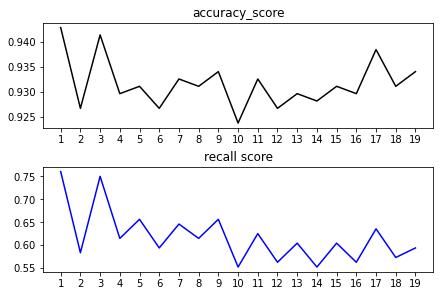

In [157]:
# plotting them to get the get the best value
fig, axes = plt.subplots(2, constrained_layout=True)
plt.setp(axes, xticks = k_range)

axes[0].plot(k_range, accs_cv, c="k")
axes[0].set_title("accuracy_score")

axes[1].plot(k_range, recalls_cv, c="b")
axes[1].set_title("recall score");


In [158]:
# from the previosu plots, it seems 3 is the optimal number for the number of neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)
y_pred_knn = knn.predict(X_test)

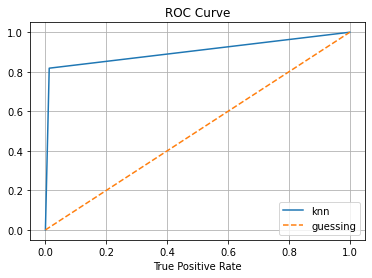

In [159]:
# Plotting the ROC Curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)
plt.plot(fpr_knn, tpr_knn, label = "knn");
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", label = "guessing")
plt.title("ROC Curve")
plt.xlabel("Flase Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()
plt.grid()

In [160]:
# Measuring the model with different classsification metrics
print(confusion_matrix(y_test, y_pred_knn))
print(f"precision: {precision_score(y_test, y_pred_knn) * 100:.2f}%")
print(f"recall: {recall_score(y_test, y_pred_knn) * 100:.2f}%")
print(f"f_1: {f1_score(y_test, y_pred_knn) * 100:.2f}%")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_knn) * 100:.2f}%")

[[158   2]
 [  2   9]]
precision: 81.82%
recall: 81.82%
f_1: 81.82%
roc_auc_score: 90.28%


Comment: the recall is 82%, which is good

# Logistic Regression

In [161]:
# Importing the Library
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [162]:
# Resetting the test and the training sets
columns = df.columns
X = df[columns[:-1]]
y = df[columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)
# comment the next line if using GridsearchCV or cross_val_predict
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state=1)


- we will use GridSearchCV to tune the hyper parameters
- we used the scoring method *i.e., goal* of the gridsearch to be `recall` since this is a medical application and we are very keen on spotting the +ve class (have covid)

In [163]:
solvers = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=grid, n_jobs=-1, cv=10, scoring='recall',error_score=0)
grid_search.fit(X_train,y_train)
print("best parameters for the model are: ")
print(grid_search.best_params_)

/home/ossamaak0/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/ossamaak0/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/ossamaak0/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/ossamaak0/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/ossamaak0/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logisti

best parameters for the model are: 
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


/home/ossamaak0/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- train the model with the best parameters chosen by gridsearch
- we give weight to the `+ve` classe to emphasize on it's importance since this is a medical application

In [165]:
# Create a logistic regression model and train it 
pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=0.1,solver='newton-cg',max_iter=1000,class_weight='balanced'))
pipe.fit(X_train, y_train)
y_pred_LR = pipe.predict(X_test)

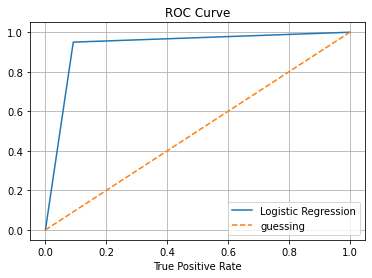

In [166]:
# Plotting the ROC Curve
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_pred_LR)
plt.plot(fpr_LR, tpr_LR, label = "Logistic Regression");
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", label = "guessing")
plt.title("ROC Curve")
plt.xlabel("Flase Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()
plt.grid()

In [167]:
# Measuring the model with different classsification metrics
print(confusion_matrix(y_test, y_pred_LR))
print(f"precision: {precision_score(y_test, y_pred_LR) * 100:.2f}%")
print(f"recall: {recall_score(y_test, y_pred_LR) * 100:.2f}%")
print(f"f_1: {f1_score(y_test, y_pred_LR) * 100:.2f}%")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_LR) * 100:.2f}%")

[[139  14]
 [  1  19]]
precision: 57.58%
recall: 95.00%
f_1: 71.70%
roc_auc_score: 92.92%


# Naive Bayes

In [168]:
# Importing the Library
from sklearn.naive_bayes import CategoricalNB

I chosed to use `CategoricalNB` according to [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB) : 
> The categorical Naive Bayes classifier is suitable for classification with discrete features that are categorically distributed.

In [169]:
# Splitting the data again with the default dataset
columns = df.columns
X = df[columns[:-1]]
y = df[columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=2)
# comment the next line if using GridsearchCV or cross_val_predict
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state=2)


In [170]:
# This will return an error, because there're negative values
NB = CategoricalNB()
NB.fit(X_train, y_train)
y_pred_NB = NB.predict(X_test)

ValueError: Negative values in data passed to CategoricalNB (input X)

after checking the plots above, the `diff_sym_hos` has negative values

In [171]:
# removing the negative values
indices = df.query("diff_sym_hos < 0").index
print(len(indices))
df_nb = df.drop(indices)

2


In [172]:
# Splitting the data again with the default dataset
columns = df_nb.columns
X = df_nb[columns[:-1]]
y = df_nb[columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=2)
# comment the next line if using GridsearchCV or cross_val_predict
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state=2)


In [175]:
NB = CategoricalNB()
NB.fit(X_train, y_train)
y_pred_NB = NB.predict(X_test)

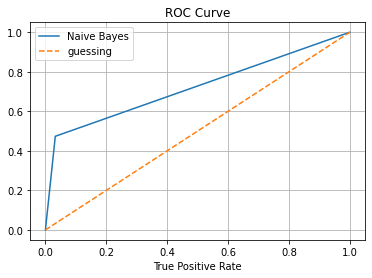

In [176]:
# Plotting the ROC Curve
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_test, y_pred_NB)
plt.plot(fpr_NB, tpr_NB, label = "Naive Bayes");
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", label = "guessing")
plt.title("ROC Curve")
plt.xlabel("Flase Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()
plt.grid()

In [177]:
# Measuring the model with different classsification metrics
print(confusion_matrix(y_test, y_pred_NB))
print(f"precision: {precision_score(y_test, y_pred_NB) * 100:.2f}%")
print(f"recall: {recall_score(y_test, y_pred_NB) * 100:.2f}%")
print(f"f_1: {f1_score(y_test, y_pred_NB) * 100:.2f}%")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_NB) * 100:.2f}%")

[[149   5]
 [ 10   9]]
precision: 64.29%
recall: 47.37%
f_1: 54.55%
roc_auc_score: 72.06%


Comment: The recall value is low, we need to improve it
- we will improve it by chaning the class priorities a little bit,

In [178]:
p0 = df_nb["result"].value_counts()[0] / df_nb["result"].value_counts().sum()
p1 = df_nb["result"].value_counts()[1] / df_nb["result"].value_counts().sum()

Setting different values to test priority changing

In [179]:
pr_changes = np.arange(0.01, 0.5, 0.01)
precisions = []
recalls = []

In [180]:
for i in pr_changes:
    NB = CategoricalNB(class_prior = [p0 - i, p1 + i])
    NB.fit(X_train, y_train)
    y_pred = NB.predict(X_test)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

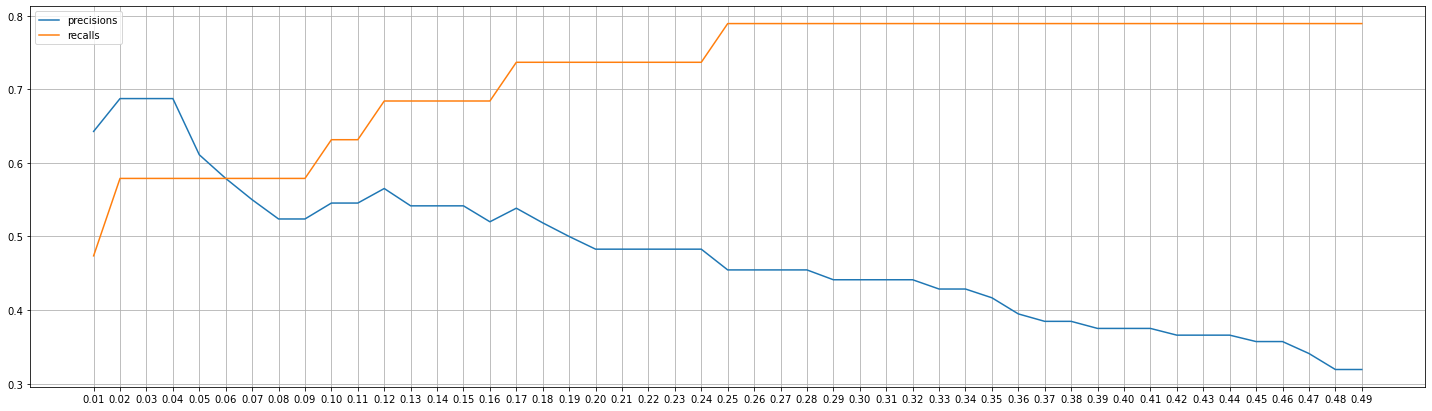

In [181]:
plt.figure(figsize=(25,7))
plt.plot(pr_changes,precisions, label = "precisions")
plt.plot(pr_changes, recalls, label = "recalls")
plt.xticks(pr_changes)
plt.grid()
plt.legend();

`0.17` is good, good recall and acceptable (even low) precision

In [182]:
NB = CategoricalNB(class_prior = [p0 - 0.17, p1 + 0.17])
NB.fit(X_train, y_train)
y_pred_NB = NB.predict(X_test)

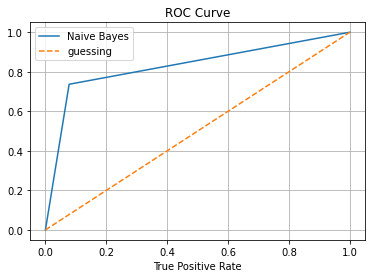

In [183]:
# Plotting the ROC Curve
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_test, y_pred_NB)
plt.plot(fpr_NB, tpr_NB, label = "Naive Bayes");
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", label = "guessing")
plt.title("ROC Curve")
plt.xlabel("Flase Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()
plt.grid()

In [184]:
# Measuring the model with different classsification metrics
print(confusion_matrix(y_test, y_pred_NB))
print(f"precision: {precision_score(y_test, y_pred_NB) * 100:.2f}%")
print(f"recall: {recall_score(y_test, y_pred_NB) * 100:.2f}%")
print(f"f_1: {f1_score(y_test, y_pred_NB) * 100:.2f}%")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_NB) * 100:.2f}%")

[[142  12]
 [  5  14]]
precision: 53.85%
recall: 73.68%
f_1: 62.22%
roc_auc_score: 82.95%


# Decision Trees

In [10]:
# Importing The Decision Trees libarries
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

In [87]:
# Splitting the data again with the default dataset
columns = df.columns
X = df[columns[:-1]]
y = df[columns[-1]]

X_train, X_test, y_train, y_test_before = train_test_split(X, y, test_size= 0.2, random_state=2)
# comment the next line if using GridsearchCV or cross_val_predict
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state=2)


In [190]:
grid = {"criterion" : ("gini", "entropy"), "max_depth" : np.arange(2, 6), "min_samples_split": np.arange(2, 6)}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid, cv = 10, n_jobs=-1, scoring= "recall")
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}


In [191]:
dt_clf = DecisionTreeClassifier(criterion= "gini", max_depth= 4, min_samples_split=2, random_state=2)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=2)

In [195]:
y_pred_DT_before = dt_clf.predict(X_test)

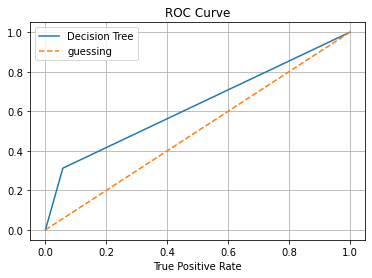

In [194]:
# Plotting the ROC Curve
fpr_DT_before, tpr_DT_before, thresholds = roc_curve(y_test_before, y_pred_DT_before)
plt.plot(fpr_DT_before, tpr_DT_before, label = "Decision Tree");
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", label = "guessing")
plt.title("ROC Curve")
plt.xlabel("Flase Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()
plt.grid()

In [196]:
# Measuring the model with different classsification metrics
print(confusion_matrix(y_test_before, y_pred_DT_before))
print(f"precision: {precision_score(y_test_before, y_pred_DT_before) * 100:.2f}%")
print(f"recall: {recall_score(y_test_before, y_pred_DT_before) * 100:.2f}%")
print(f"f_1: {f1_score(y_test_before, y_pred_DT_before) * 100:.2f}%")
print(f"roc_auc_score: {roc_auc_score(y_test_before, y_pred_DT_before) * 100:.2f}%")

[[148   9]
 [ 11   5]]
precision: 35.71%
recall: 31.25%
f_1: 33.33%
roc_auc_score: 62.76%


in order to reduce the length of the decision tree: we will check if we can **remove some columns**

### 1) The country Column

In [197]:
# the country column

# get all values
countries = df["country"].unique()


# check the percentage of death to total for each one
countries_percentages = {}



for country in countries:
    countries_percentages[country] =  len(df.query(f"result == 0 & country == {country}")) / len(df.query(f"country == {country}"))

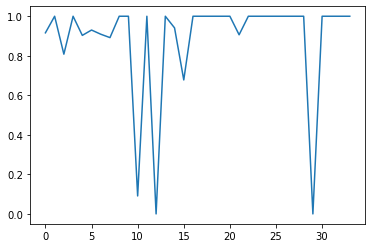

In [198]:
plt.plot(countries_percentages.values());

Comment: Different percentage prevents us from removing this column

### 2) The gender Column

In [199]:
# the gender column

# get all values
genders = df["gender"].unique()


# check the percentages of death to total for each one
genders_percentages = {}



for gender in genders:
    genders_percentages[gender] =  len(df.query(f"result == 0 & gender == {gender}")) / len(df.query(f"gender == {gender}"))

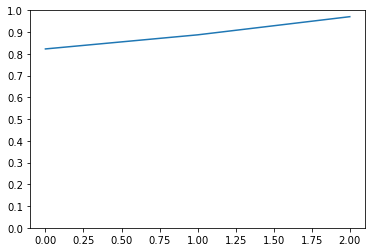

In [200]:
plt.plot(genders_percentages.values());
plt.yticks(np.linspace(0, 1, 11));

Comment: they are quite similar. we can try removing this column without losing too much data

In [201]:
df_dt = df.drop(columns = ["gender"])

In [202]:
# Splitting the data
columns = df_dt.columns
X = df_dt[columns[:-1]]
y = df_dt[columns[-1]]

X_train, X_test, y_train, y_test_after = train_test_split(X, y, test_size= 0.2, random_state=1)
# comment the next line if using GridsearchCV or cross_val_predict
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state=2)


In [203]:
grid = {"criterion" : ("gini", "entropy"), "max_depth" : np.arange(2, 6), "min_samples_split": np.arange(2, 6)}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid, cv = 10, n_jobs=-1, scoring= "recall")
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


In [205]:
dt_clf = DecisionTreeClassifier(criterion= "gini", max_depth= 5, min_samples_split=2, random_state=2)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=2)

In [206]:
y_pred_DT_after = dt_clf.predict(X_test)

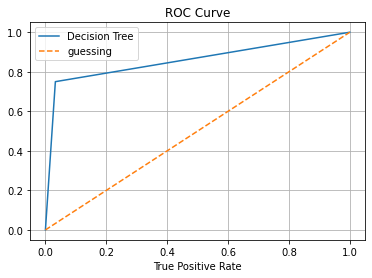

In [212]:
# Plotting the ROC Curve
fpr_DT_after, tpr_DT_after, thresholds_DT_after = roc_curve(y_test_after, y_pred_DT_after)
plt.plot(fpr_DT_after, tpr_DT_after, label = "Decision Tree");
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", label = "guessing")
plt.title("ROC Curve")
plt.xlabel("Flase Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()
plt.grid()

In [208]:
# Measuring the model with different classsification metrics
print(confusion_matrix(y_test_after, y_pred_DT_after))
print(f"precision: {precision_score(y_test_after, y_pred_DT_after) * 100:.2f}%")
print(f"recall: {recall_score(y_test_after, y_pred_DT_after) * 100:.2f}%")
print(f"f_1: {f1_score(y_test_after, y_pred_DT_after) * 100:.2f}%")
print(f"roc_auc_score: {roc_auc_score(y_test_after, y_pred_DT_after) * 100:.2f}%")

[[148   5]
 [  5  15]]
precision: 75.00%
recall: 75.00%
f_1: 75.00%
roc_auc_score: 85.87%


## Compare the results before and after removing the column

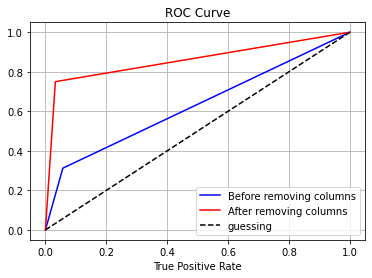

In [218]:
# Plotting the ROC Curve
plt.plot(fpr_DT_before, tpr_DT_before, label = "Before removing columns", c="b");
plt.plot(fpr_DT_after, tpr_DT_after, label = "After removing columns", c="r");

plt.plot(np.array([0, 1]), np.array([0, 1]), "--", label = "guessing", c="k")
plt.title("ROC Curve")
plt.xlabel("Flase Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()
plt.grid()

Comment: The data is better after removing the columns, we will take the second result

### Tree visualization

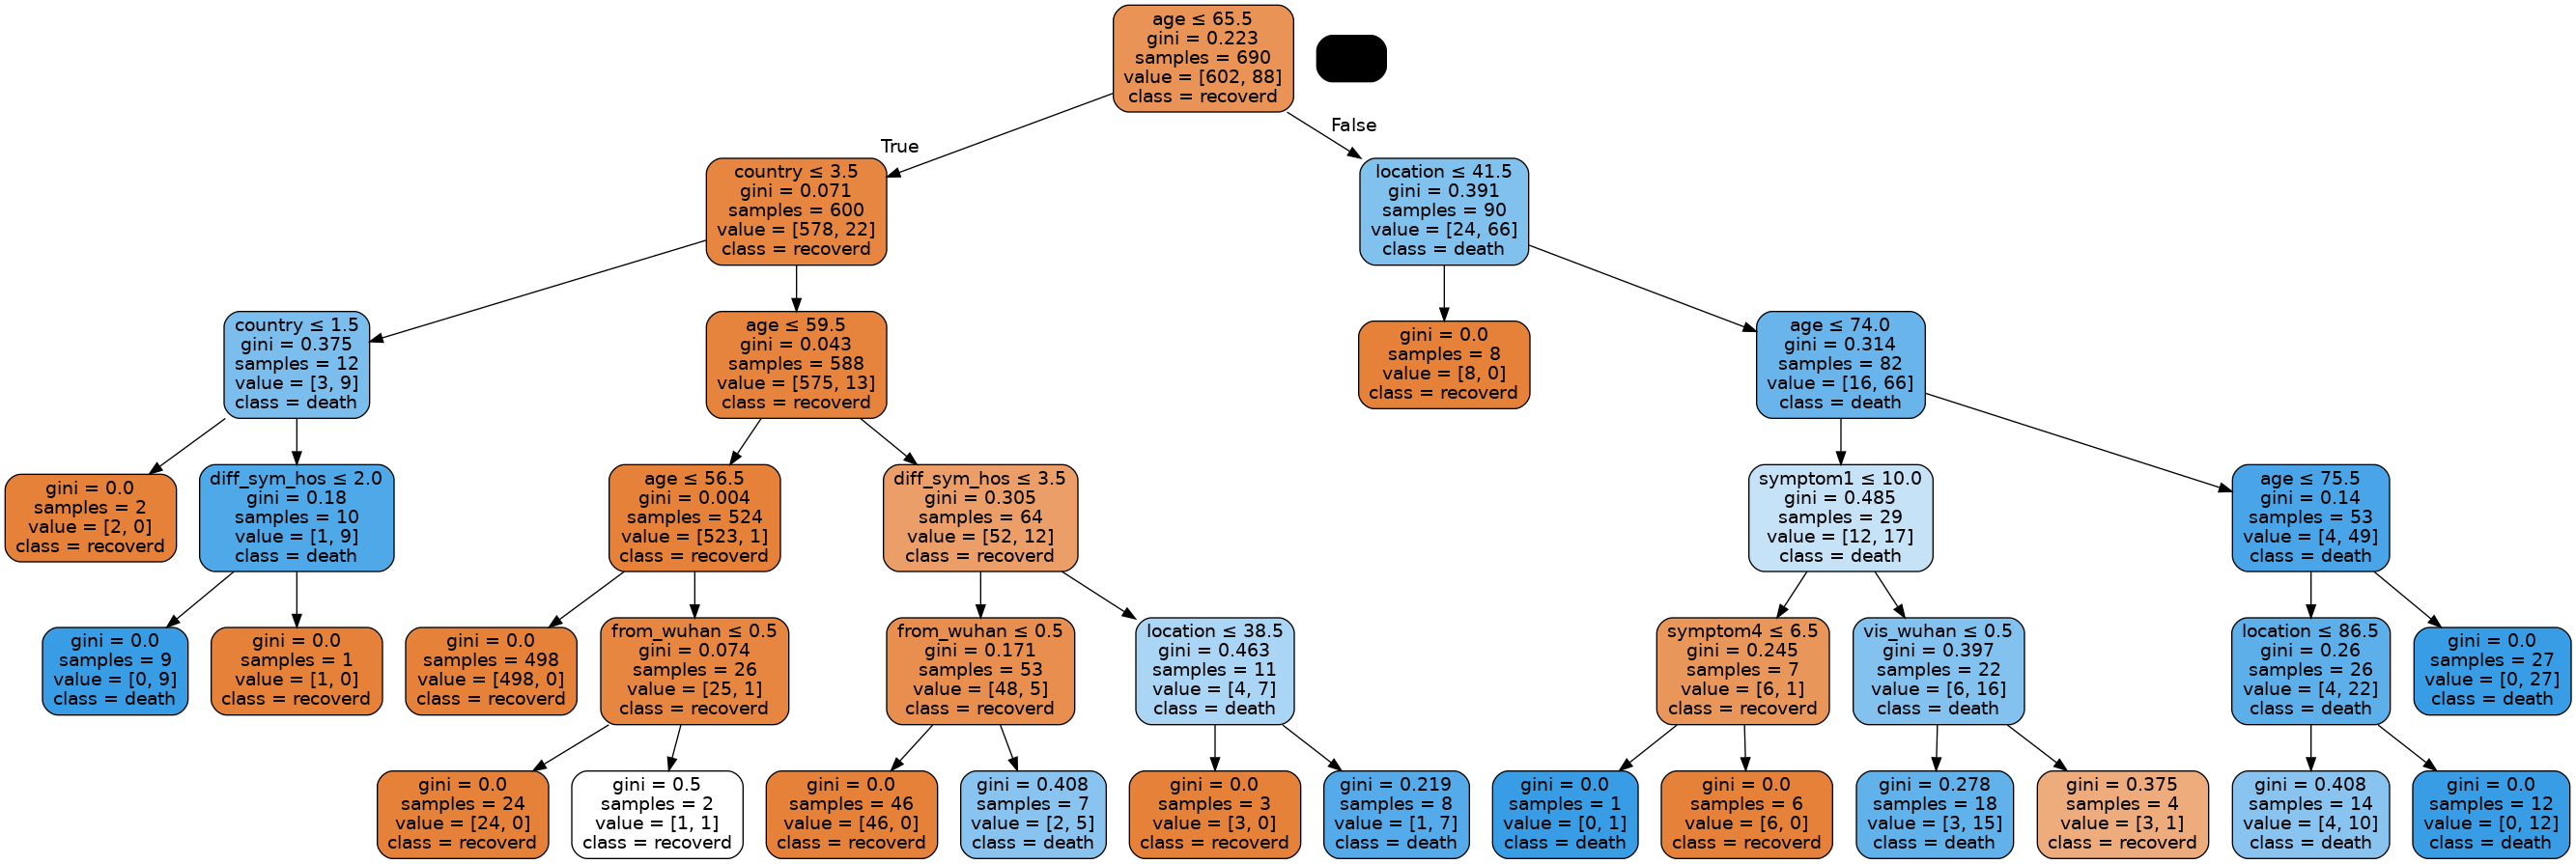

In [219]:
dot_data = StringIO()
export_graphviz(dt_clf, out_file= dot_data, rounded= True, filled= True, special_characters= True, feature_names= df_dt.columns[:-1], class_names= ["recoverd", "death"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write("Decision Tree.png")
Image(graph.create_png())

# SVM

In [220]:
# Importing the library
from sklearn.svm import SVC


In [221]:
# Resetting the test and the training sets
columns = df.columns
X = df[columns[:-1]]
y = df[columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)
# comment the next line if using GridsearchCV or cross_val_predict
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state=1)


### The hyperparameters of SVM classifier 
- C: Regularization parameter.The strength of the regularization is inversely    proportional to C
- kernel: usually used for creating some features out of the existing features to transform it to another dimension where it is easy to classify 
- class weight: since this is a medical application we might give some weight to the +ve class 

we used the scoring method (i.e. goal) of the gridsearch to be "recall" since this is a medical application and we are very keen on spotting the +ve class (have covid)

we will use GridSearchCV to tune the hyper parameters

In [222]:
kernel = ['linear','poly','rbf','sigmoid']
c_values = [100, 10, 1.0, 0.1, 0.01]
gamma = ['scale','auto']
grid = dict(kernel=kernel,gamma=gamma,C=c_values)
grid_search = GridSearchCV(estimator=SVC(), param_grid=grid, n_jobs=-1, cv=10, scoring='balanced_accuracy',error_score=0)
grid_search.fit(X_train,y_train)
print("best parameters for the model are: ")
print(grid_search.best_params_)

best parameters for the model are: 
{'C': 100, 'gamma': 'auto', 'kernel': 'poly'}


## Training the model with the chosen parameters

In [226]:
model = SVC(C=1000,gamma='scale',kernel='rbf',class_weight='balanced')
model.fit(X_train, y_train)

SVC(C=1000, class_weight='balanced')

In [227]:
y_pred_SVM = model.predict(X_test)

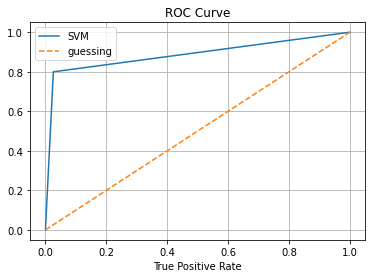

In [228]:
# Plotting the ROC Curve
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(y_test, y_pred_SVM)
plt.plot(fpr_SVM, tpr_SVM, label = "SVM");
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", label = "guessing")
plt.title("ROC Curve")
plt.xlabel("Flase Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()
plt.grid()

In [232]:
# Measuring the model with different classsification metrics
print(confusion_matrix(y_test, y_pred_SVM))
print(f"precision: {precision_score(y_test, y_pred_SVM) * 100:.2f}%")
print(f"recall: {recall_score(y_test, y_pred_SVM) * 100:.2f}%")
print(f"f_1: {f1_score(y_test, y_pred_SVM) * 100:.2f}%")
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_SVM) * 100:.2f}%")

[[149   4]
 [  4  16]]
precision: 80.00%
recall: 80.00%
f_1: 80.00%
roc_auc_score: 88.69%


# Comparsion bet ROC curves of all classifiers

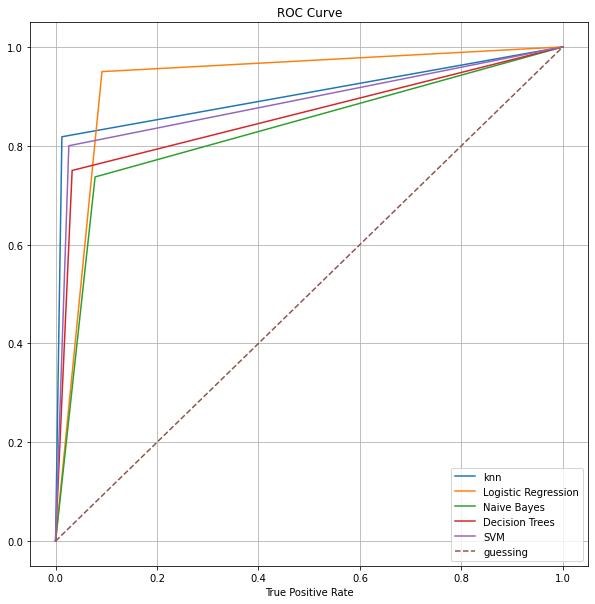

In [231]:
plt.figure(figsize=(10,10))
plt.plot(fpr_knn, tpr_knn, label = "knn");
plt.plot(fpr_LR, tpr_LR, label = "Logistic Regression");
plt.plot(fpr_NB, tpr_NB, label = "Naive Bayes");
plt.plot(fpr_DT_after, tpr_DT_after, label = "Decision Trees");
plt.plot(fpr_SVM, tpr_SVM, label = "SVM");
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", label = "guessing")
plt.title("ROC Curve")
plt.xlabel("Flase Positive Rate")
plt.xlabel("True Positive Rate")
plt.legend()
plt.grid()